## Optimizing Debt Collection in Public Services: Data-Driven Strategies

### Preparation

#### Data ingestion

In [14]:
from helper import plot_all_cat_freq, remove_outliers, create_stacked_bar_plot,  Pipeline, cv,plot_binary_correlation
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

df = pd.read_parquet('utilities_disconnection.parquet')
df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,"252,39",complete,"662,62",4,2017-03-06,circuit_break,"66,0",circuit_break,"0,0"
1,1,1,14071,1,1,single-phase connection,disconnected,"0,0",None,"1202,45",17,2017-03-31,circuit_break,"73,0",circuit_break,"0,0"
2,2,1,12380,1,1,biphasic connection,disconnected,"0,0",None,"352,56",1,2017-03-20,circuit_break,"20,0",circuit_break,"0,0"
3,3,1,14071,1,1,biphasic connection,disconnected,"1317,25",complete,"699,23",9,2017-03-29,pole,"73,0",pole,"0,0"
4,4,2,22212,1,1,biphasic connection,disconnected,"2172,29",complete,"484,1",4,2017-03-16,pole,"156,0",circuit_break,"0,0"


### Preprocessing

#### Data type coercion

In [15]:
categorical = [
    'client_id',
    'regional', 
    'site', 
    'client_class', 
    'client_subclass', 
    'connection_type', 
    'connection_status', 
    'installment_status', 
    'disconnection_requested',
    'contractor_id',
    'disconnection_executed'
    ]

numerical = [
    'installment_value',
    'total_debt',
    'total_bills',
    ]

datetime = [
    'disconnection_date'
    ]

target = 'collected'

df[categorical] = df[categorical].astype('object')
for col in numerical:
    df[col] = df[col].astype(str).str.replace(",", ".").astype('float')
df[datetime] = df[datetime].apply(pd.to_datetime)
df[target] = df[target].astype(str).str.replace(",",".").astype('float')
df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,252.39,complete,662.62,4.0,2017-03-06,circuit_break,"66,0",circuit_break,0.0
1,1,1,14071,1,1,single-phase connection,disconnected,0.00,None,1202.45,17.0,2017-03-31,circuit_break,"73,0",circuit_break,0.0
2,2,1,12380,1,1,biphasic connection,disconnected,0.00,None,352.56,1.0,2017-03-20,circuit_break,"20,0",circuit_break,0.0
3,3,1,14071,1,1,biphasic connection,disconnected,1317.25,complete,699.23,9.0,2017-03-29,pole,"73,0",pole,0.0
4,4,2,22212,1,1,biphasic connection,disconnected,2172.29,complete,484.10,4.0,2017-03-16,pole,"156,0",circuit_break,0.0


#### Null values

In [16]:
df.isna().sum()

client_id                       0
regional                        0
site                            0
client_class                    0
client_subclass                 0
connection_type                 0
connection_status               0
installment_value               0
installment_status         370785
total_debt                      0
total_bills                     0
disconnection_date              0
disconnection_requested         0
contractor_id                   0
disconnection_executed          0
collected                       0
dtype: int64

Pela documentação, esses valores faltantes na coluna ``installment_status`` se referem à casos onde não se aplica, então incluiremos essa nova categoria. 

In [17]:
df.fillna('N/A', inplace=True)

#### Duplicates

In [18]:
print(f'Existem {df.shape[0] - df.drop_duplicates().shape[0]} linhas repetidas')

Existem 142 linhas repetidas


In [19]:
df.drop_duplicates(inplace=True)

### Initial Data Analysis

array([[<Axes: title={'center': 'installment_value'}>,
        <Axes: title={'center': 'total_debt'}>,
        <Axes: title={'center': 'total_bills'}>]], dtype=object)

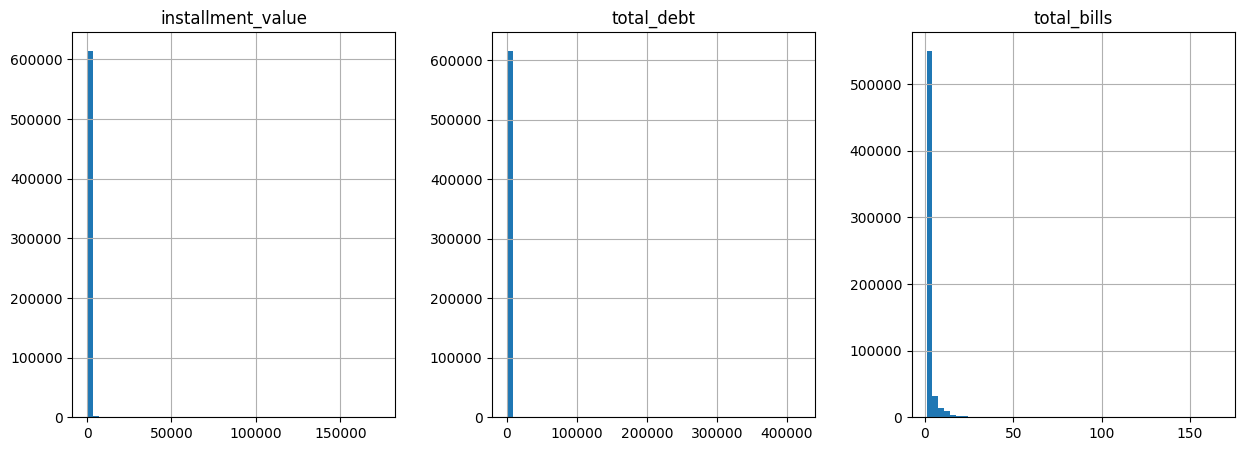

In [20]:
df[numerical].hist(bins = 50, figsize=(15,5),layout = (1,3))

The distribution of numerical variables is severely affected by outliers.

array([[<Axes: title={'center': 'installment_value'}>,
        <Axes: title={'center': 'total_debt'}>,
        <Axes: title={'center': 'total_bills'}>]], dtype=object)

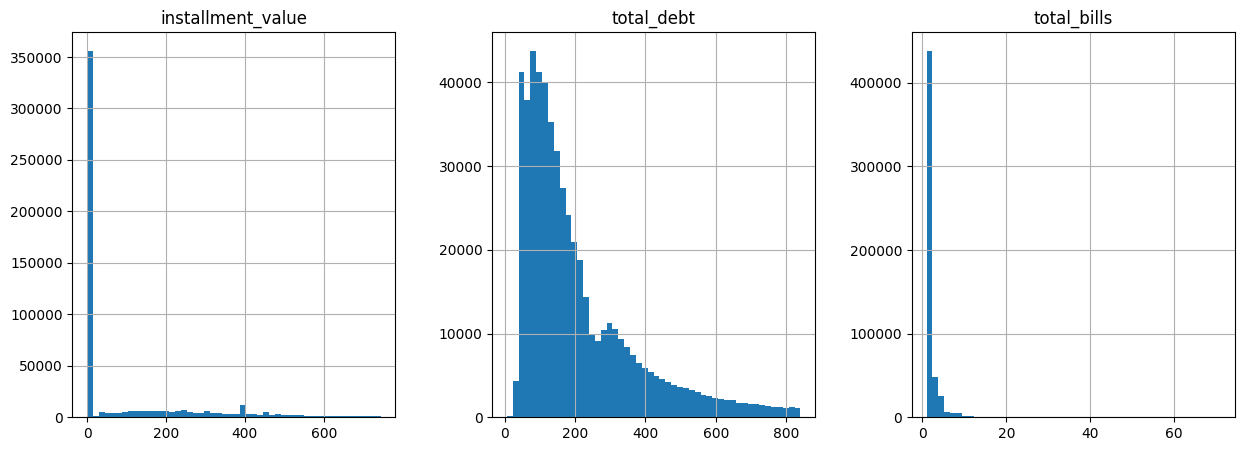

In [21]:
df_filtered = df.loc[df.index.isin(remove_outliers(df[['installment_value', 'total_debt']], bound_const=2))].reset_index(drop=True)
df_filtered[numerical].hist(bins = 50, figsize=(15,5),layout = (1,3))

<Axes: xlabel='total_debt', ylabel='total_bills'>

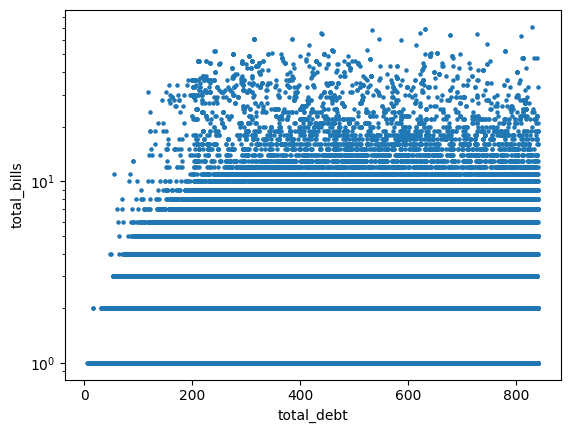

In [22]:
df_filtered.plot(x = 'total_debt', y= 'total_bills', kind = 'scatter', s=5 , logy = True)

With the removal of outliers, it is possible to observe the behavior of the values in the column `total_debts`, which has a large number of records between 0 and 250, exhibiting a new peak near 300 and a decline in frequency as values increase.

Given this distribution, it is possible to categorize total debts into 3 categories:
- Small debts: Representing the first peak in the debt distribution, ranging between 0 and 250.
- Medium debts: Representing the second curve, ranging between 250 and 800.
- High debts: Representing high values that deviate from the general data behavior, with values greater than 800.

From the second graph, it can also be concluded that for low values of `total_bills`, there are `total_debt` values present in almost all ranges, indicating the presence of different bill amounts, becoming more distributed (and rarer) for values above 10.

Regarding the ``installment_value`` variable, a predominance of zero values is noticeable, even after the removal of outliers.

#### New variable

In [23]:
df['total_debt_class'] = df['total_debt'].apply(lambda x: 'P' if 0 <= x <= 250 else 'M' if 250 < x < 800 else 'G')
categorical.append('total_debt_class')

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

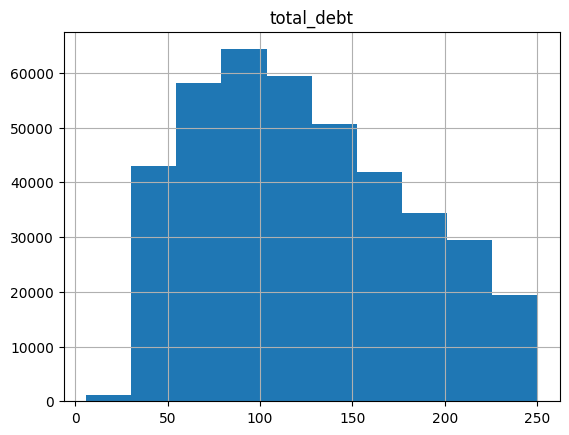

In [24]:
df.loc[df.total_debt_class == 'P',['total_debt']].hist()

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

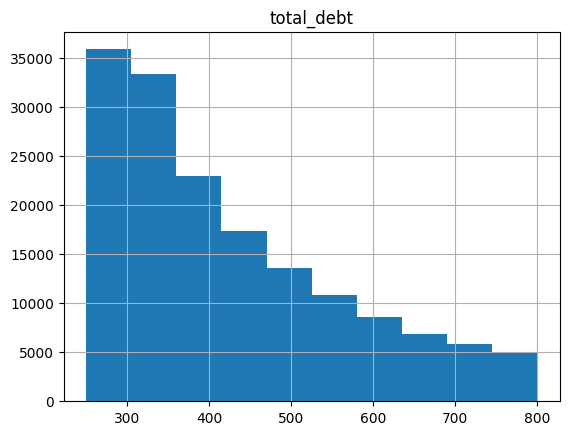

In [25]:
df.loc[df.total_debt_class == 'M',['total_debt']].hist()

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

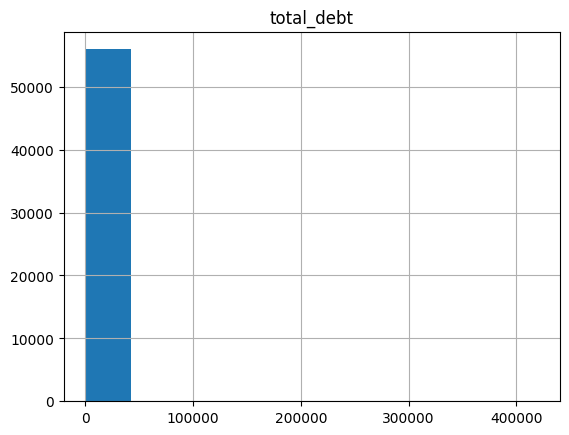

In [26]:
df.loc[df.total_debt_class == 'G',['total_debt']].hist()

#### Exploring categorical variables

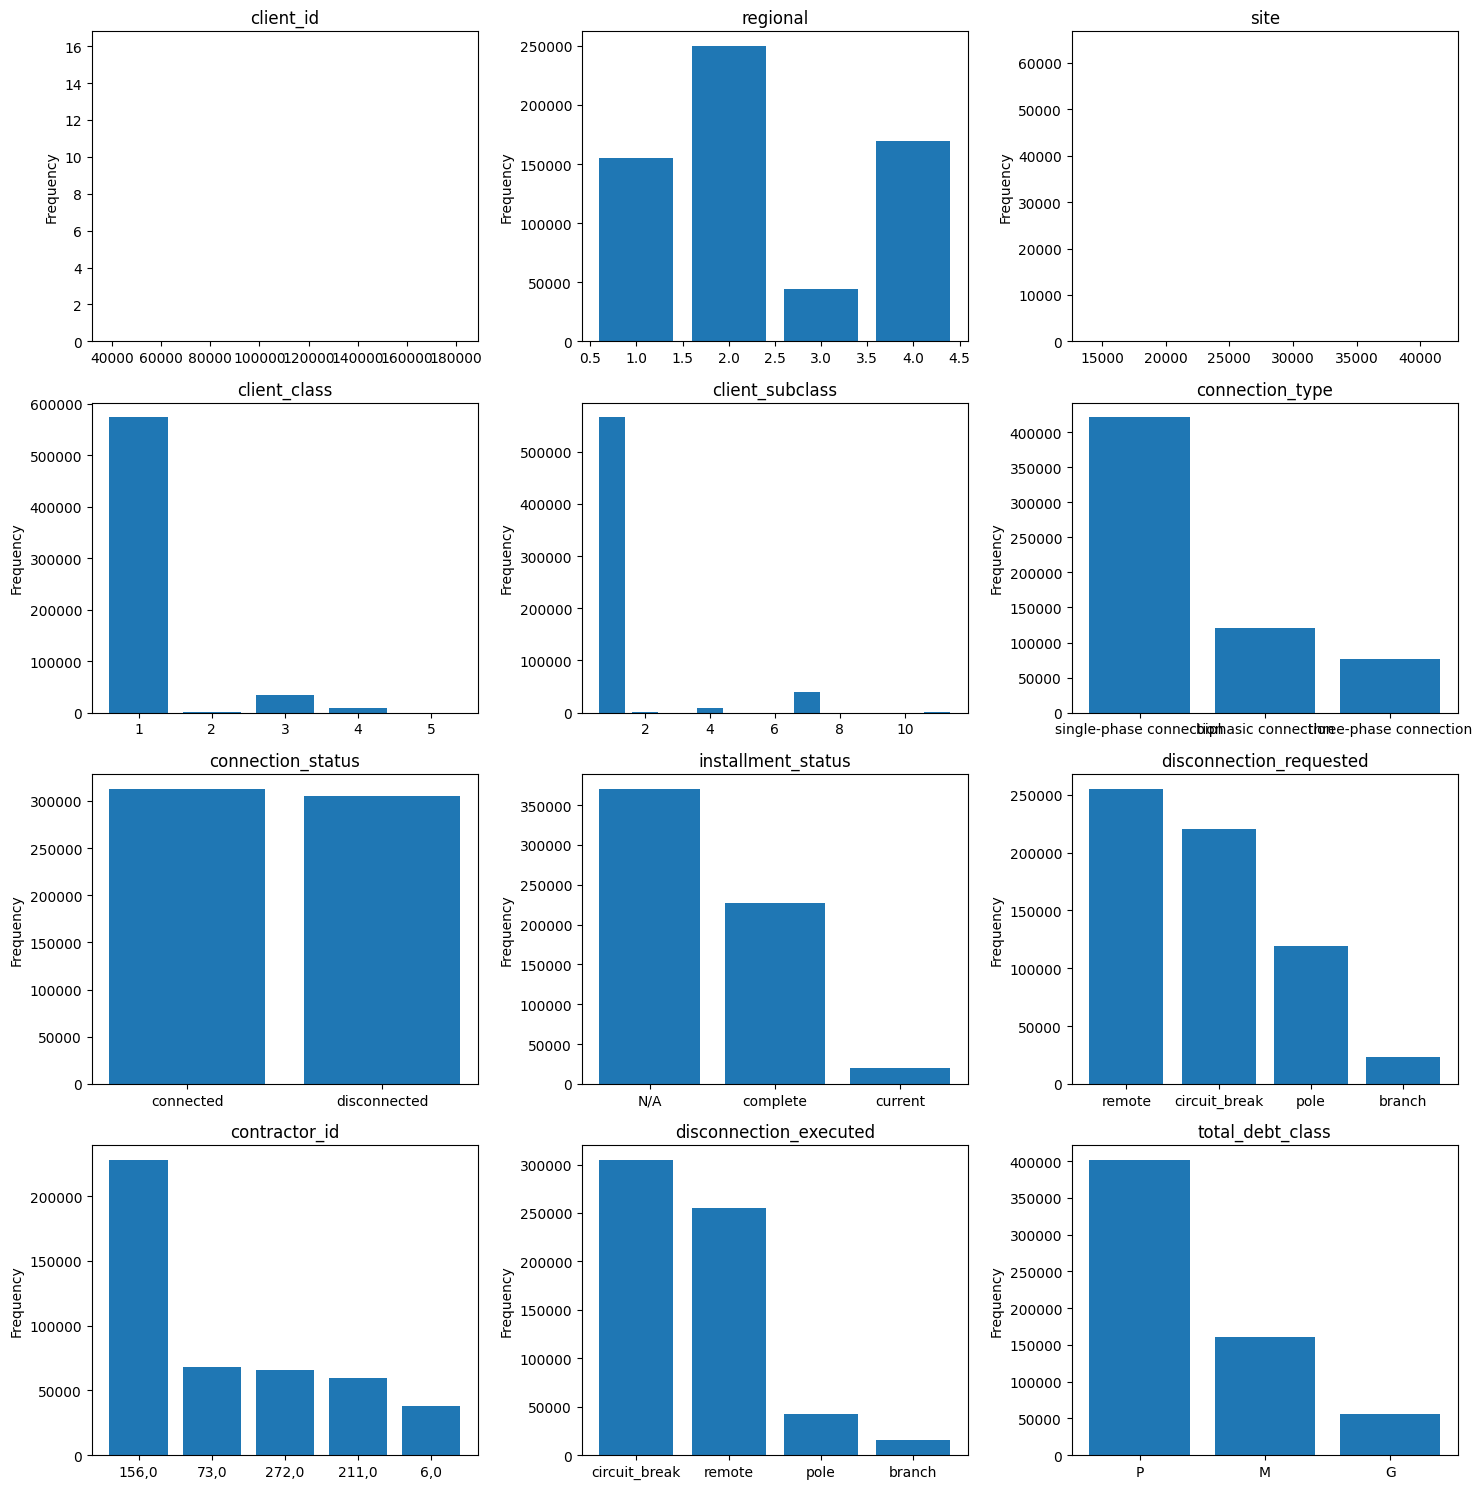

In [27]:
plot_all_cat_freq(df[categorical])

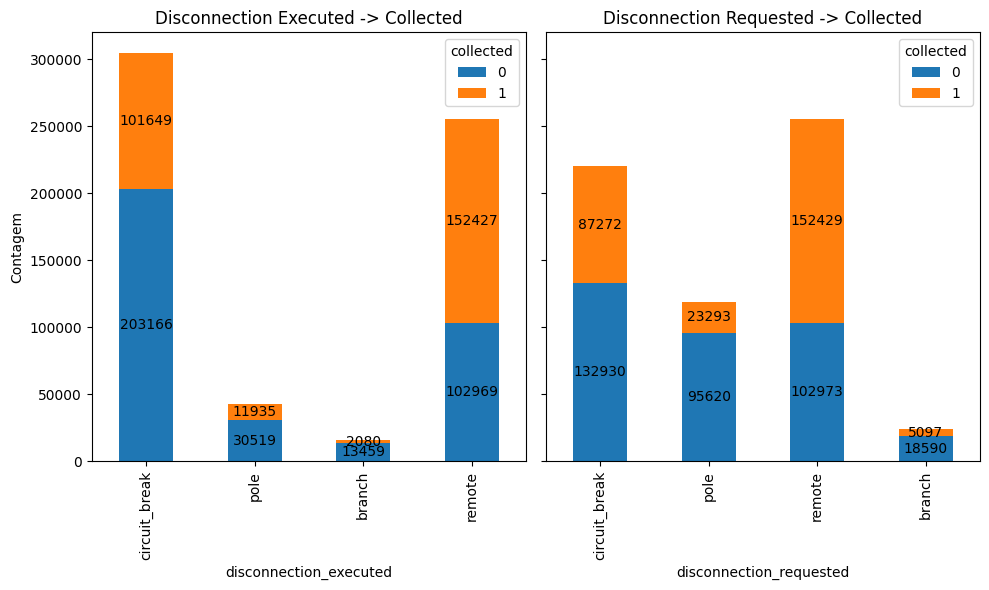

In [28]:
# Creating the subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plotting each analysis
create_stacked_bar_plot(axs[0], df, 'disconnection_executed', 'collected', "Disconnection Executed -> Collected")
create_stacked_bar_plot(axs[1], df, 'disconnection_requested', 'collected', "Disconnection Requested -> Collected")

plt.tight_layout()
plt.show()

Circuit disconnection and remote disconnection were the ones with the highest success rate, with remote disconnection being the most efficient.

Pole disconnection and branch disconnection were not as frequent, largely due to their aggressive nature and being necessary on extreme cases.

In [29]:
df.loc[:,['disconnection_requested', 'disconnection_executed', 'collected']].groupby(['disconnection_requested', 'disconnection_executed']).agg(['count','mean','sum'])

collected                    
                                                   count      mean       sum
disconnection_requested disconnection_executed                              
branch                  branch                      3332  0.192977     643.0
                        circuit_break              16188  0.206079    3336.0
                        pole                        4166  0.268123    1117.0
                        remote                         1  1.000000       1.0
circuit_break           branch                      2198  0.368517     810.0
                        circuit_break             207222  0.394794   81810.0
                        pole                       10774  0.431316    4647.0
                        remote                         8  0.625000       5.0
pole                    branch                     10009  0.062644     627.0
                        circuit_break              81390  0.202666   16495.0
                        pole                       27512  0.224229    6169.0
                        remote                         2  1.000000       2.0
remote                  circuit_break                 15  0.533333       8.0
                        pole                           2  1.000000       2.0
                        remote                    255385  0.596820  152419.0

- Requests for remote disconnection are usually carried out as intended.
- Requests for pole and branch disconnection are not always executed, typically replaced by circuit disconnection.

---

#### Plotting the percentage of collected charges for each of the used categories, including their confidence intervals.

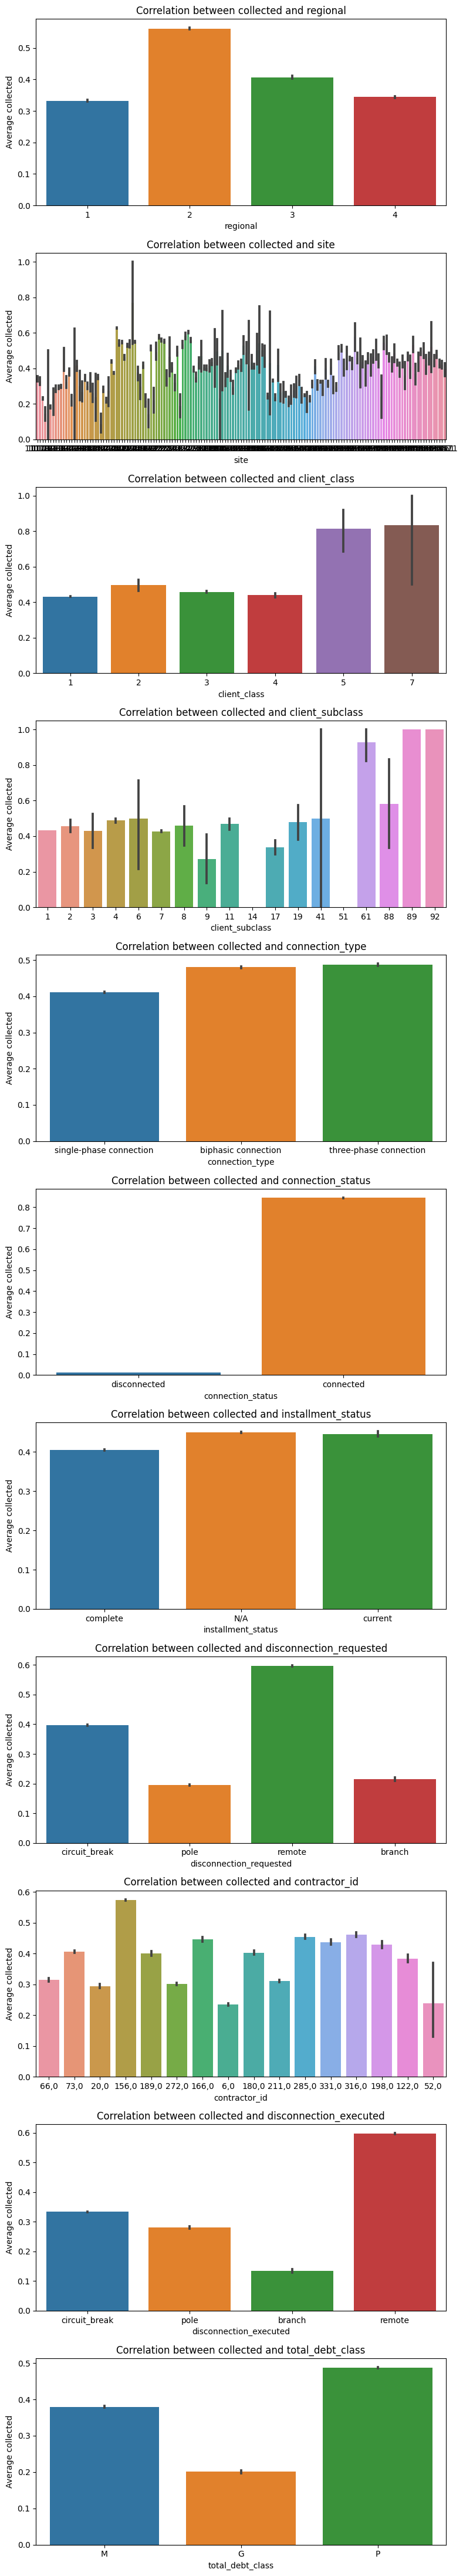

In [30]:
categorical.remove('client_id')
plot_binary_correlation(df[categorical+[target]], target)

- It is noticeable that the success rate of debit collection is very high for cases where the connection status is "connected" and significantly lower for "disconnected" statuses.

- Analyzing the variable ``total_debt_class``, it can also be observed that the success rate of charge collection decreases as the size of the debt increases.

- The execution of remote disconnection has a significantly higher success rate compared to other methods, most likely because these are clients who might already be inclined to pay, thus requiring less aggressive measures.


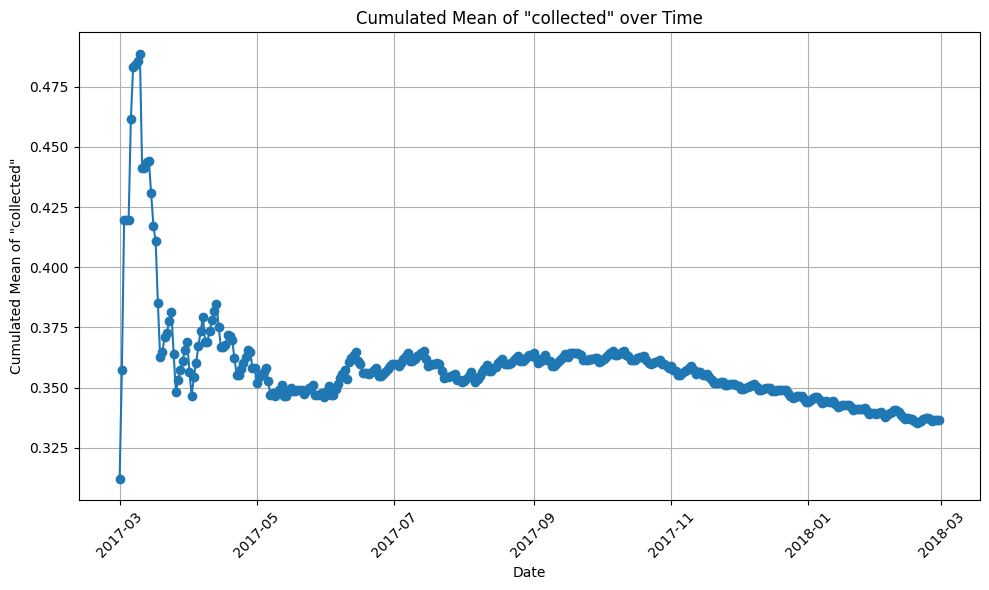

In [31]:
df_date = df.set_index('disconnection_date')

df_daily_mean = df_date[['collected']].resample('D').mean()

df_daily_mean['Cumulative_Mean'] = df_daily_mean['collected'].expanding().mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_daily_mean.index, df_daily_mean['Cumulative_Mean'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "collected"')
plt.title('Cumulated Mean of "collected" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


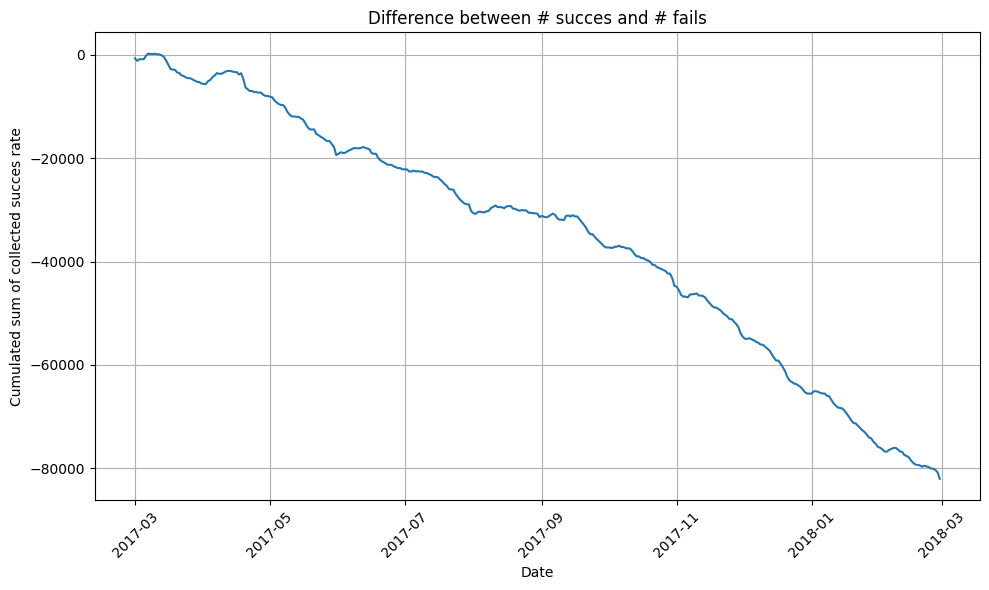

In [32]:
df_date = df.set_index('disconnection_date')
df_date.loc[df_date.collected == 0, ['collected']] = -1

df_daily_sum = df_date[['collected']].resample('D').sum()

df_daily_sum['Cumulative_sum'] = df_daily_sum['collected'].expanding().sum()

plt.figure(figsize=(10, 6))
plt.plot(df_daily_sum.index, df_daily_sum['Cumulative_sum'],linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated sum of collected succes rate')
plt.title('Difference between # succes and # fails')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Throughout almost the entire period, there were more failures in debt collection than successes, despite having points of inflection in the curve, which adds even more significance to the main problem.

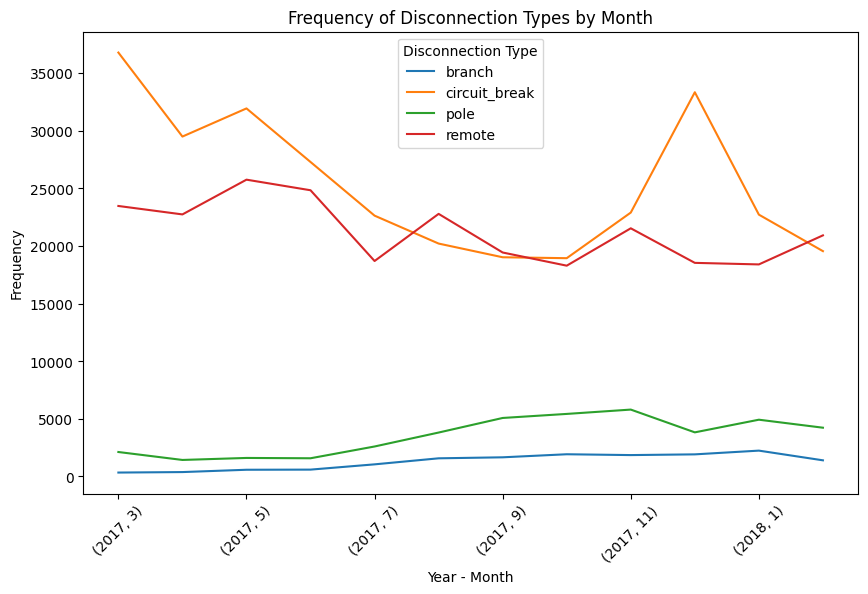

In [33]:
df_pivot = df.loc[:, ['disconnection_executed', 'disconnection_date']]

df_pivot['year'] = df_pivot['disconnection_date'].dt.year
df_pivot['month'] = df_pivot['disconnection_date'].dt.month

freq_data = df_pivot.groupby(['year', 'month', 'disconnection_executed']).size().reset_index(name='frequency')
pivot_data = freq_data.pivot(index=['year', 'month'], columns=['disconnection_executed'], values='frequency').fillna(0)

# Plot the data using a stacked bar plot
pivot_data.plot(kind='line',  figsize=(10, 6))
plt.title('Frequency of Disconnection Types by Month')
plt.xlabel('Year - Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Disconnection Type')
plt.show()

The number of pole and branch disconnections experienced a slight increase over the months. The frequency of remote disconnections did not show much variation, which could indicate a service saturation (hypothesis). The occurrences of circuit_break executions exhibited peaks at different times.

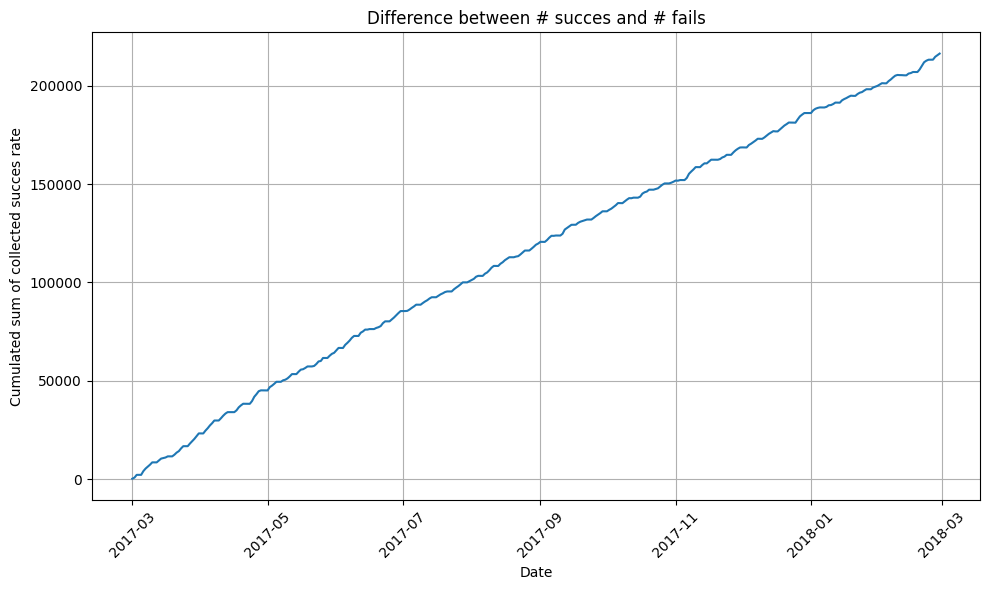

In [34]:
df_date = df.set_index('disconnection_date')

df_date = df_date.loc[df_date.connection_status == 'connected']
df_date.loc[df_date.collected == 0, ['collected']] = -1

df_daily_sum = df_date[['collected']].resample('D').sum()
df_daily_sum['Cumulative_sum'] = df_daily_sum['collected'].expanding().sum()

plt.figure(figsize=(10, 6))
plt.plot(df_daily_sum.index, df_daily_sum['Cumulative_sum'],linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated sum of collected succes rate')
plt.title('Difference between # succes and # fails')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When analyzing the success rate while the connection is active at the time of the charge, there is a clear continuous increase in the number of successes, further reinforcing that it is a strong characteristic when trying to unserstand whether the debt will be collected or not.

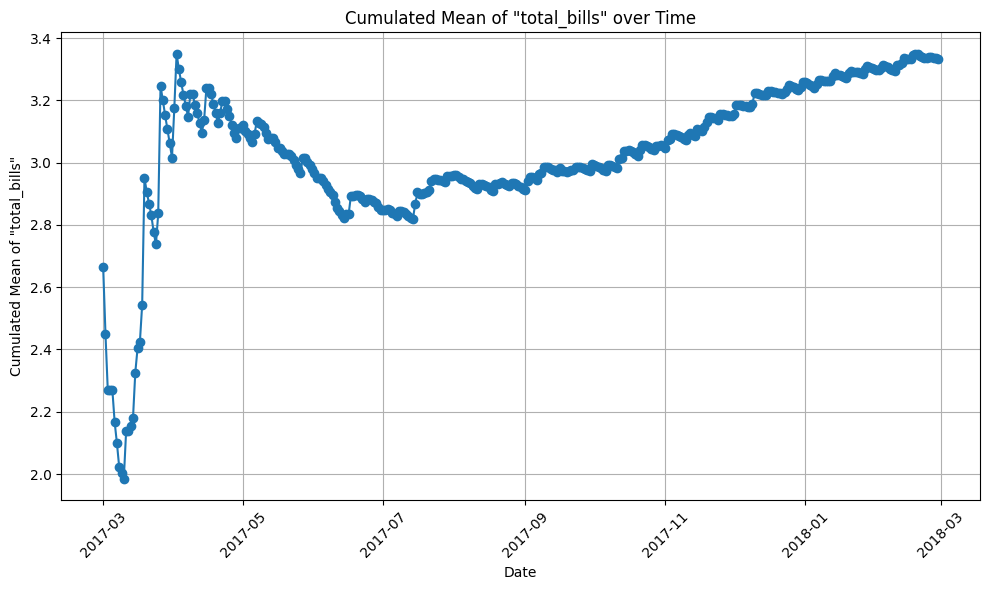

In [35]:
df_date = df.set_index('disconnection_date')

df_daily_mean = df_date[['total_bills']].resample('D').mean()
df_daily_mean['Cumulative_Mean'] = df_daily_mean['total_bills'].expanding().mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_daily_mean.index, df_daily_mean['Cumulative_Mean'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "total_bills"')
plt.title('Cumulated Mean of "total_bills" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The daily average of the total bills for customers who experience disconnection on each day is approximately 3. This suggests that customers who don't pay and need to be disconnected tend to let bills accumulate, which could also be one of the reasons for the low success rate in collections.

## Feature Engineering

According to the exploration, it is observed that there are customers in the dataframe who experience multiple disconnections, and I believe that the payment recurrence has a significant impact when deciding whether a given customer will make the payment.

Let's create the variables ``num_disconnection_until_now`` and ``num_collected_until_now``.

In [36]:
df.sort_values(by='disconnection_date', inplace=True)

hash_client = {}
num_disconnection_until_now = []
num_collected_until_now = []
for index, row in df.iterrows():
    if row['client_id'] not in hash_client:
        num_disconnection_until_now.append(0)
        num_collected_until_now.append(0)
        hash_client[row['client_id']] = [1,row['collected']]
    else:
        num_disconnection_until_now.append(hash_client[row['client_id']][0])
        num_collected_until_now.append(hash_client[row['client_id']][1])
        hash_client[row['client_id']][0] += 1
        hash_client[row['client_id']][1] += row['collected']


In [37]:
df['num_disconnection_until_now'] = num_disconnection_until_now
df['num_collected_until_now'] = num_collected_until_now

In [38]:
df.loc[:,['num_collected_until_now', 'num_disconnection_until_now']].describe()

,num_collected_until_now,num_disconnection_until_now
count,618204.000000,618204.000000
mean,0.234356,0.569238
std,0.673306,1.116050
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,11.000000,15.000000


In [39]:
df.loc[df.client_id == 2038]

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected,total_debt_class,num_disconnection_until_now,num_collected_until_now
1416,2038,1,12390,1,1,single-phase connection,disconnected,0.0,N/A,127.59,1.0,2017-03-01,circuit_break,"20,0",circuit_break,1.0,P,0,0.0
39635,2038,1,12390,1,1,single-phase connection,disconnected,0.0,N/A,127.59,1.0,2017-03-21,circuit_break,"20,0",circuit_break,0.0,P,1,1.0


Obs: The total_debt remained unchanged even after the payment on 01/03.

In [40]:
df.loc[df.client_id == 526963]

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected,total_debt_class,num_disconnection_until_now,num_collected_until_now
308660,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,42.44,1.0,2017-08-21,remote,"156,0",remote,1.0,P,0,0.0
415533,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,49.17,1.0,2017-11-01,remote,"156,0",remote,1.0,P,1,1.0
527893,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,88.76,1.0,2018-01-03,remote,"156,0",remote,1.0,P,2,2.0
616451,526963,2,21025,1,1,biphasic connection,connected,656.17,complete,193.01,1.0,2018-02-28,remote,"156,0",remote,1.0,P,3,3.0


Here there is a greater variation.

array([[<Axes: title={'center': 'num_disconnection_until_now'}>,
        <Axes: title={'center': 'num_collected_until_now'}>]],
      dtype=object)

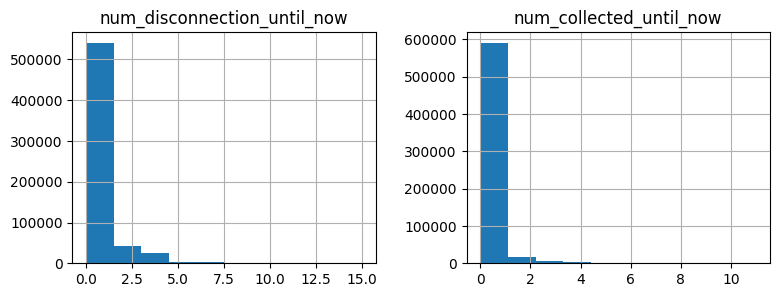

In [48]:
df.loc[:,['num_disconnection_until_now', 'num_collected_until_now']].hist(figsize=(9,3))

The two new features have many zero values due to the numerous distinct customers in the dataset, but they help provide a better understanding of the payment history of each customer.

-----------

### Selection of Important Variables for Root Cause Analysis

The objective of the project is to create an efficient disconnection request methodology, which can be divided into two main fronts:

1. **Increasing the Debt Collection Success Rate**
2. **Reducing Costs without Decreasing Debt Collection Performance**

To achieve this, we can categorize the influencing characteristics into three main groups:

#### Customer and Product-Related Features

- `client_class`: Provides insights into the customer's profile.
- `regional`: Indicates potential differentiation between demographic info about the client.
- `connection_status`: An important feature, with two distinct behaviors – one with a very high success rate and another with a very low rate.

#### Payment Dimension

- `total_debts`: Directly impacts the customer's payment decision.
- `total_debt_class`: Categorizes the customer's debt size.
- `total_bills`: Reflects customer recurrence and historical payment pattern.
- `num_collected_until_now`: Indicates prior payments, suggesting a higher likelihood to repeat payments.
- `num_disconnection_until_now`: Highlights customer recurrence through the number of disconnections.

#### Executed Collection Action

- `disconnection_executed`: Indicates the action taken, impacting costs and customer experience.

By focusing on these variables and groups, the project aims to develop an effective way to predict the debt collection success, reducing costs, and improving performance.


Among these variables, we will further select the most relevant ones from the model's perspective.

### Feature selection

To prevent data leakage and ensure real-world applicability, the dataset will be divided prior to conducting any model-related analyses.

Given the temporal nature of the model, the complete dataset will be partitioned into three subsets:

- **Training Data**: This subset will be utilized for model training and will encompass the available information.
- **Testing Data**: These data points will be used to evaluate and compare the model's performance metrics.
- **Validation Data**: This subset will serve as the final evaluation metrics for the project, emulating predictions for new data.

The dataset will be split according to the following proportions:
- Training: 70%
- Testing: 20%
- Validation: 10%

The validation set will specifically have the most recent records, maintaining the temporal relationship of the data.

This approach ensures a robust evaluation of the model's performance while safeguarding against data leakage and maintaining the temporal context.


In [21]:
categorical = [
    'regional', 
    'client_class',
    'connection_status',
    'disconnection_executed'
]
numerical = [
    'total_debt',
    'total_bills'
]
datetime = [
    'disconnection_date'
]
target= 'collected'

pipeline_01 = Pipeline(df, categorical, numerical, 'collected')
pipeline_01.preprocessing()

#### Machine Learning Model selection

Para selecionar o modelo a ser utilizado, precisa-se ter em mente que é um modelo de classificação binária, uma vez que a variável objetivo possui apenas duas categorias. Para isso, selecionei 7 modelos para uma busca por seus hiperparâmetros. Baseado no que foi visto até então, modelos que são robustos a outliers e que performam bem com variáveis categóricas e numéricas tendem a obter uma melhor performance

## Model Selection for Binary Classification

To select the model for this task, it's important to remember that we are dealing with a binary classification problem since the target variable has only two categories. With this in mind, I have chosen 7 models to undergo a hyperparameter search. Based on the insights gathered so far, models that demonstrate resilience to outliers and excel in handling both categorical and numerical variables tend to achieve superior performance.

The following 7 models have been selected for hyperparameter tuning:

1. LogisticRegression
2. RandomForestClassifier
3. AdaBoostClassifier
4. LinearSVC
5. MLPClassifier
6. RidgeClassifier
7. DecisionTreeClassifier

By evaluating these models across a range of hyperparameters and considering their ability to handle the dataset's characteristics – including outliers and a mix of variable types – we aim to identify the model that is best suited for the task.

Once the hyperparameter tuning is completed, we will assess and compare the models using appropriate evaluation metrics. This approach ensures that we select a model that offers robust, accurate, and interpretable results for the binary classification challenge.

In [ ]:
mlflow.set_experiment('Model Selection')

# Define the parameter grid for each model
param_grid = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.05, 0.1, 1.0, 10.0]
    },
    'RandomForestClassifier': {
        'n_estimators': [200, 500],
        'max_depth': [None, 20, 30]
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20]
    },
    'RidgeClassifier': {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0]
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
        'activation': ['relu', 'tanh'],
    },
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],
        'max_iter': [1000, 2000, 5000]
    }
}

models = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, RidgeClassifier, AdaBoostClassifier, MLPClassifier, LinearSVC]

for model in models:
    model_name = model.__name__
    param_grid_model = param_grid[model_name]

    with mlflow.start_run():
        clf = model()
        grid_search = GridSearchCV(clf, param_grid_model, n_jobs=-1, scoring='precision', refit=True)
        grid_search.fit(pipeline_01.X_processed, pipeline_01.y_processed)
        predict = grid_search.predict(pipeline_01.X_processed_test)
        f1 = f1_score(pipeline_01.y_processed_test, predict)
        prec = precision_score(pipeline_01.y_processed_test, predict)
        rec = recall_score(pipeline_01.y_processed_test, predict)
        acc = accuracy_score(pipeline_01.y_processed_test, predict)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("model", model_name)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("accuracy", acc)


![image.png](images\model_selection.PNG)

As expected, all the results were very close to each other, which suggests a strong correlation with the ``connection_status`` variable.

In [23]:
model = LogisticRegression(
            random_state=42,
            max_iter=500,
            C=0.1,
        )
num_folds = 5
cv_Precision = cv(pipeline_01.X_processed.values, pipeline_01.y_processed.values,  model, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_Precision}')

model.fit(pipeline_01.X_processed.values, pipeline_01.y_processed.values.ravel())
y_pred = model.predict(pipeline_01.X_processed_test.values)
test_Precision= precision_score(pipeline_01.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_Precision:.4f}')


5-Fold Cross Validation Precision: [0.8436943315214909, 0.8441434912582662, 0.8441673279673506, 0.8462044856079179, 0.8451317400571403]
Test Set Precision: 0.8424


In [24]:
(pipeline_01.X_processed_test.connection_status_connected.values == y_pred).sum()/len(y_pred)

0.9991426792083532

The model's prediction is almost 100% linked to the connection_status variable.

Let's develop a simple algorithm to try to bring some feature importance to the model with all variables except connection_status.

In [90]:
categorical = [
    'regional', 
    'client_class',
    'disconnection_executed',
    'total_debt_class'
]
numerical = [
    'total_debt',
    'total_bills',
    'num_collected_until_now',
    'num_disconnection_until_now'
]
datetime = [
    'disconnection_date'
]
target= 'collected'

teste_features = Pipeline(df, categorical, numerical, 'collected')
teste_features.preprocessing()

In [92]:
model = RandomForestClassifier(random_state=42, n_estimators=200)
model.fit(teste_features.X_processed.values, teste_features.y_processed.values.ravel())
fi = {x:y for x,y in zip(teste_features.X_processed.columns, model.feature_importances_)}
sorted_fi = {k: v for k, v in sorted(fi.items(), key=lambda item: item[1], reverse=True)}
sorted_fi

{'total_debt': 0.5926202301785344,
 'total_bills': 0.17329435971680765,
 'num_disconnection_until_now': 0.05337893596008732,
 'disconnection_executed_remote': 0.05153864044950355,
 'num_collected_until_now': 0.047737223010265194,
 'regional_2': 0.020110573090398338,
 'disconnection_executed_circuit_break': 0.01775556110208627,
 'total_debt_class_P': 0.008182958839649592,
 'total_debt_class_G': 0.007316113247626727,
 'regional_1': 0.005653766527012395,
 'disconnection_executed_branch': 0.00422303332833224,
 'regional_4': 0.004134583780561647,
 'disconnection_executed_pole': 0.003545059383706371,
 'client_class_1': 0.002348447645961883,
 'regional_3': 0.002251197398514984,
 'total_debt_class_M': 0.0022431864250312093,
 'client_class_3': 0.001959468304002165,
 'client_class_4': 0.0012203195248536775,
 'client_class_2': 0.0004194951653974806,
 'client_class_5': 3.7038025722198006e-05,
 'client_class_7': 2.9808895944812596e-05}

Contrary to the initial hypothesis, it is noticed that the client_class variable has a much smaller influence on the prediction outcome.

Based on the previous result, we will select the variables:

- ``total_debt``
- ``total_bills``
- ``num_disconnection_until_now``
- ``num_collected_until_now``
- ``disconnection_executed``
- ``regional``

This demonstrates that customer account-related features have much more impact on the decision.

In [93]:
categorical = ['regional',
    'disconnection_executed'
]
numerical = [
    'total_debt',
    'total_bills',
    'num_collected_until_now',
    'num_disconnection_until_now'
]
target= 'collected'

pipeline_02 = Pipeline(df, categorical, numerical, 'collected')
pipeline_02.preprocessing()

Running the grid search for hyperparameter optimization (which could be more extensive with additional resources and time available).

In [ ]:
mlflow.set_experiment('Model Selection_v4')

# Define the parameter grid for each model
param_grid = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.05, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
    },
    'RandomForestClassifier': {
        'n_estimators': [200],
        'max_depth': [None, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5],
        'max_features': ['auto','sqrt']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'max_features': ['auto', 'sqrt']
    },
    'RidgeClassifier': {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'fit_intercept': [True, False]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],
        'max_iter': [1000, 2000, 5000],
        'penalty': ['l1', 'l2']
    }
}

models = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, RidgeClassifier, AdaBoostClassifier, LinearSVC]

for model in models:
    model_name = model.__name__
    param_grid_model = param_grid[model_name]

    with mlflow.start_run():
        clf = model()
        grid_search = GridSearchCV(clf, param_grid_model, scoring='precision', refit=True, n_jobs=-1, verbose = 5)
        grid_search.fit(pipeline_02.X_processed, pipeline_02.y_processed.values.ravel())
        predict = grid_search.predict(pipeline_02.X_processed_test)
        f1 = f1_score(pipeline_02.y_processed_test, predict)
        prec = precision_score(pipeline_02.y_processed_test, predict)
        rec = recall_score(pipeline_02.y_processed_test, predict)
        acc = accuracy_score(pipeline_02.y_processed_test, predict)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("model", model_name)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("accuracy", acc)


![image.png](images\model_selection2.PNG)

Among the selected models, DecisionTreeClassifier and RandomForestClassifier achieved the best performances.

**DecisionTreeClassifier:**

Pros:

- Easy to understand and interpret, as it represents a tree-like structure.
- Requires less data preprocessing.

Cons:

- Tends to overfit.
- Is sensitive to small variations in training data.

**RandomForestClassifier:**

Pros:

- Reduces overfitting by aggregating predictions from multiple trees.
- Improves overall accuracy compared to a single decision tree.
- Can handle a large number of attributes and is less sensitive to small variations in data.

Cons:

- May be more challenging to interpret than a single decision tree.
- Can be computationally more expensive to train and predict, especially on large datasets.

Let's use both models for cross-validation to assess their generalization capabilities.

In [95]:
modelo_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    criterion='entropy'
)
modelo_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10
)

Decision Tree

In [96]:
num_folds = 5
cv_f1 = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_dt, num_folds, metric=f1_score)
print(f'5-Fold Cross Validation F1-Score: {cv_f1}')

modelo_dt.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_dt.predict(pipeline_02.X_processed_test.values)
test_f1= f1_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set F1-Score: {test_f1:.4f}')

5-Fold Cross Validation F1-Score: [0.6903386014992225, 0.6825634801646795, 0.6783965654470467, 0.6887361481273672, 0.6860122207280535]
Test Set F1-Score: 0.6874


Random Forest

In [97]:
num_folds = 5
cv_f1 = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_rf, num_folds, metric=f1_score)
print(f'5-Fold Cross Validation F1-Score: {cv_f1}')

modelo_rf.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_rf.predict(pipeline_02.X_processed_test.values)
test_f1= f1_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set F1-Score: {test_f1:.4f}')

5-Fold Cross Validation F1-Score: [0.6720911514663717, 0.6800843902088178, 0.6807209488432091, 0.681475840898545, 0.6821217324937988]


c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Set F1-Score: 0.6814


In both methods, the results obtained from cross-validation closely resemble the general behavior of the training dataset. This suggests that there doesn't appear to be overfitting in either case.

#### Scores

**Precision:**

Precision measures the ratio of true positives to the total instances classified as positive. In other words, it indicates the model's ability to correctly predict a positive class. The formula is: Precision = True Positives / (True Positives + False Positives).

**Recall:**

Recall, also known as sensitivity or true positive rate, measures the ratio of correctly identified positive instances by the model to the total truly positive instances. In simple terms, it's the model's ability to find all relevant instances. The formula is: Recall = True Positives / (True Positives + False Negatives).

**F1-score:**

The F1-score is a metric that combines precision and recall to provide a balance between the two measures. It's particularly useful when dealing with class imbalance, as it considers both false positives and false negatives. The closer it is to 1, the better the model's performance in terms of precision and recall. The formula is: F1-Score = 2 * (Precision * Recall) / (Precision + Recall).

**Accuracy:**

Accuracy is the most common and straightforward measure, representing the ratio of correct predictions to the total predictions made by the model. It's useful when all classes have similar importance and the dataset is well balanced. The formula is: Accuracy = (True Positives + True Negatives) / Total.

<img src="images\Precisão_e_revocação.png" alt="Descrição da imagem" width="300" height="600" />

We opt for using <font color="red">precision</font> as the reference for defining the model's quality, as it increases with the reduction of False Positives. False Positives represent cases where the model predicts that the customer would pay the debt, but in reality, they wouldn't. This emphasizes the importance of minimizing such incorrect positive predictions to ensure accurate identification of customers who will actually pay.

In [98]:
num_folds = 5
cv_precision = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_dt, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_precision}')

modelo_dt.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_dt.predict(pipeline_02.X_processed_test.values)
test_precision= precision_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_precision:.4f}')

5-Fold Cross Validation Precision: [0.6123852266644707, 0.6191740604019601, 0.6220723211323675, 0.6170667336936031, 0.6189442315879098]
Test Set Precision: 0.6179


In [100]:
cv_precision = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  modelo_rf, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_precision}')

5-Fold Cross Validation Precision: [0.6375501049818668, 0.6206813557096909, 0.6192628650904033, 0.6193205164248178, 0.6209022621683817]
Test Set Precision: 0.6179


In [102]:
y_pred = modelo_rf.predict(pipeline_02.X_processed_test.values)
test_precision = precision_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_precision:.4f}')

Test Set Precision: 0.6202


Once again, the cross-validation results closely resemble those of the test dataset, indicating that there was no overfitting.

As a final validation step, let's test some dummy models to ensure that the program has truly learned from the provided variables:

In [104]:
for strategy in ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']:
    dummy_clf = DummyClassifier(strategy = strategy, constant=1)
    dummy_clf.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
    y_pred_dummy = dummy_clf.predict(pipeline_02.X_processed_test.values)
    print(f'Utilizando a estratégia {strategy}: Prec = {precision_score(pipeline_02.y_processed_test,y_pred_dummy):.2f}')

c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Utilizando a estratégia most_frequent: Prec = 0.00
Utilizando a estratégia prior: Prec = 0.00
Utilizando a estratégia stratified: Prec = 0.44
Utilizando a estratégia uniform: Prec = 0.44
Utilizando a estratégia constant: Prec = 0.44


In this way, there was an increase in precision of approximately 40%.

Let's test a voting ensemble model that combines both models and observe its metrics.

In [44]:
eclf = VotingClassifier( estimators=[('dt', DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    criterion='entropy'
)), ('rf', RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10
))], voting='soft', n_jobs = -1)

cv_precision = cv(pipeline_02.X_processed.values, pipeline_02.y_processed.values,  eclf, num_folds, metric=precision_score)
print(f'5-Fold Cross Validation Precision: {cv_precision}')

modelo_rf.fit(pipeline_02.X_processed.values, pipeline_02.y_processed)
y_pred = modelo_rf.predict(pipeline_02.X_processed_test.values)
test_precision = precision_score(pipeline_02.y_processed_test.values,y_pred)
print(f'Test Set Precision: {test_precision:.4f}')

5-Fold Cross Validation Precision: [0.6183429803104793, 0.6145196828930332, 0.6120364302018124, 0.6144043663977219, 0.6157473531478836]


c:\Users\leonardodomingos\.virtualenvs\LeonardoDomingosKearney-Q09UpS7u\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Set Precision: 0.6100


There were no significant improvements observed.

### Predictions

Let's proceed with using the DecisionTreeClassifier model, which performs equally well and is much smaller than the Random Forest model. This makes it more feasible for potential deployment within the company's production environment.

To make predictions, we will use the validation dataset, which includes the most recent records from this dataset. This provides an indication of how the model would perform with real-world and unseen data that it has not encountered during any stage of its training or evaluation.

In [41]:
categorical = ['regional',
    'disconnection_executed'
]
numerical = [
    'total_debt',
    'total_bills',
    'num_collected_until_now',
    'num_disconnection_until_now'
]
target= 'collected'

modelo_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    criterion='entropy'
)
pipeline_03 = Pipeline(df, categorical, numerical, 'collected')
pipeline_03.preprocessing()
pipeline_03.df_val

df_val = pipeline_03.df_val.loc[:,pipeline_03.categorical+pipeline_03.numerical+[pipeline_03.target]]
X = df_val.drop([target], axis = 1)
y = df_val[[target]]

X_categorical_val = pd.DataFrame(pipeline_03.cat_encoder.transform(X[pipeline_03.categorical]), columns=pipeline_03.cat_encoder.get_feature_names_out())
X_numeric_normalized_val = pd.DataFrame(pipeline_03.num_normalizer.transform(X[pipeline_03.numerical]), columns=pipeline_03.numerical)
X_processed_val = pd.concat([X_categorical_val, X_numeric_normalized_val], axis=1)

modelo_dt.fit(pipeline_03.X_processed.values, pipeline_03.y_processed)
y_pred = modelo_dt.predict(X_processed_val.values)

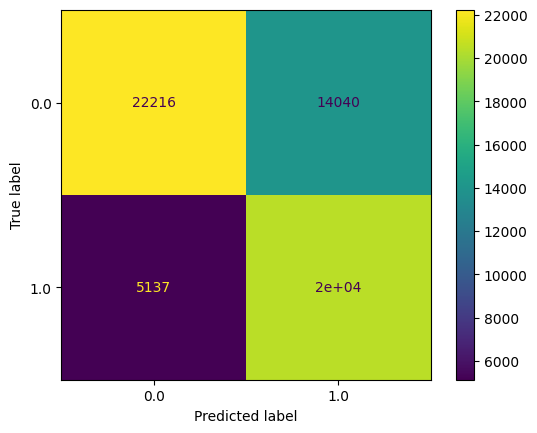

In [42]:
cm = confusion_matrix(y.values.ravel(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelo_dt.classes_)
disp.plot()

In [43]:
prec = precision_score(y.values.ravel(), y_pred)
acc = accuracy_score(y.values.ravel(), y_pred)
rec = recall_score(y.values.ravel(), y_pred)
f1 = f1_score(y.values.ravel(), y_pred)
print(f'''The precision score were: {prec:.2f}
Other relevant metrics:
    - Accuracy = {acc:.2f}
    - Recall = {rec:.2f}
    - F1-score = {f1:.2f}''')

The precision score were: 0.59
Other relevant metrics:
    - Accuracy = 0.69
    - Recall = 0.80
    - F1-score = 0.68


In [45]:
df_val

,regional,disconnection_executed,total_debt,total_bills,num_collected_until_now,num_disconnection_until_now,collected
617411,1,pole,1151.44,3.0,0.0,0,0.0
617397,4,pole,598.39,2.0,0.0,0,0.0
617398,2,circuit_break,331.49,3.0,0.0,0,0.0
617399,1,circuit_break,946.80,6.0,0.0,2,0.0
617400,1,circuit_break,435.65,4.0,0.0,2,0.0
...,...,...,...,...,...,...,...
557341,2,remote,53.49,1.0,0.0,0,0.0
557342,2,remote,195.19,1.0,0.0,0,0.0
557343,2,remote,104.28,1.0,0.0,0,1.0
557344,2,remote,299.21,1.0,1.0,1,0.0


In [49]:
df.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_val


,index,regional,disconnection_executed,total_debt,total_bills,num_collected_until_now,num_disconnection_until_now,collected
0,617411,1,pole,1151.44,3.0,0.0,0,0.0
1,617397,4,pole,598.39,2.0,0.0,0,0.0
2,617398,2,circuit_break,331.49,3.0,0.0,0,0.0
3,617399,1,circuit_break,946.80,6.0,0.0,2,0.0
4,617400,1,circuit_break,435.65,4.0,0.0,2,0.0
...,...,...,...,...,...,...,...,...
61815,557341,2,remote,53.49,1.0,0.0,0,0.0
61816,557342,2,remote,195.19,1.0,0.0,0,0.0
61817,557343,2,remote,104.28,1.0,0.0,0,1.0
61818,557344,2,remote,299.21,1.0,1.0,1,0.0


In [54]:

df_final = pd.merge(left = df, right = df_val, how = 'right',on='index')
df_final = df_final.drop(['index',
       'total_debt_class', 'num_disconnection_until_now_x',
       'num_collected_until_now_x', 'regional_y', 'disconnection_executed_y',
       'total_debt_y', 'total_bills_y', 'num_collected_until_now_y',
       'num_disconnection_until_now_y', 'collected_y' ], axis = 1)

In [57]:
df_final.columns = ['client_id', 'regional', 'site', 'client_class', 'client_subclass',
       'connection_type', 'connection_status', 'installment_value',
       'installment_status', 'total_debt', 'total_bills',
       'disconnection_date', 'disconnection_requested', 'contractor_id',
       'disconnection_executed', 'collected']

In [58]:
df_final['collected_predicted'] = y_pred

In [ ]:

df_final.to_csv('LEONARDO_DOMINGOS_E_LUNA_SILVA_PREDICTIONS.csv')

### Feature Importance

In [109]:
fi = {x:y for x,y in zip(pipeline_03.X_processed.columns,modelo_dt.feature_importances_)}

{k: v for k, v in sorted(fi.items(), key=lambda item: item[1], reverse=True)}

{'total_bills': 0.3442147002713619,
 'disconnection_executed_remote': 0.30813280799260395,
 'total_debt': 0.12411675358991749,
 'num_collected_until_now': 0.11346012806988191,
 'num_disconnection_until_now': 0.08965850533677965,
 'regional_1': 0.008371492568634063,
 'regional_3': 0.005193110081763683,
 'disconnection_executed_branch': 0.002402848648825664,
 'regional_4': 0.0017146439284508356,
 'regional_2': 0.0010177086287052764,
 'disconnection_executed_pole': 0.0009932713283473495,
 'disconnection_executed_circuit_break': 0.0007240295547281494}

The 5 most relevant features are:

- ``total_bills``
- ``disconnection_executed_remote``
- ``total_debt``
- ``num_collected_until_now``
- ``num_disconnection_until_now``

-----

## Business sense and technical background

### Conclusions about the Model

With the objective of reducing costs and enhancing the efficiency of the billing methodology, a series of analyses were conducted on the dataset about a vital factor for the performance improvement of this methodology: predicting whether users will pay or not.

This metric holds significance in comprehending the anticipated return from a potential disconnection, helping the company in deciding which customers to channel efforts and investments towards. Moreover, it facilitates the analysis of the true factors that steer a customer towards bill payment or non-payment.

The model exhibited a satisfactory performance in this predictive task, with decision tree models emerging as the better solutions in effectiveness, largely attributed to their capability to handle the outliers identified within the dataset.

Two principal analyses were made: the first includes the connection_status category, which exhibited outstanding performance with a Precision metric score of <font color="yellow">**0.84**</font>. However, this was shown to be significantly influenced by this variable. Subsequent to this, upon its exclusion and the selection of significant features, a <font color="yellow">**0.62**</font> score was achieved on the test dataset. Finally, the Decision Tree model was chosen because it's faster and lighter, yet it achieved similar results to the Random Forest. It had a Precision metric of <font color="yellow">**0.59**</font> on the validation dataset, which is similar to what was achieved in the testing phases.

---------

### Recommendations for the company:

Based on the provided dataset, there are 3 main recommendations:

- The current connection status is a strong indicator to understand whether the customer will pay or not, even stronger than the disconnection method. Customers who are connected at the time of billing are more likely to pay their debts. A suggestion is to primarily focus efforts on this group of customers and gather more information to confirm if this trend holds for different time periods.
- Payment history and debt size are also relevant factors for customer decisions, even more relevant than their profile characteristics. Therefore, concentrating efforts on understanding these payment patterns and categorizing these customers for collection campaigns can help ensure predictability for collections.
- The remote disconnection method has proven to be very effective in encouraging customers to actually pay their bills, contrary to expectations considering the assertiveness of the collection efforts. Thus, it's recommended to better understand the potential reasons behind this increased efficiency.

In addition to these points, the model will also assist in individual predictions for each customer, allowing for prioritization of efforts. It's important to closely monitor the model's metrics, as it is inherently sensitive to new information, potentially requiring model retraining.

------

### Next Steps:

Based on the 3 suggestions, I believe there are 3 data extensions that can help the model provide better predictions:

- Additional data about the current connection status, such as time connected since product subscription, usage frequency, connection size, and others, can help understand which characteristics are responsible for the strong relationship with debt payment. Generally, these data points should be obtainable through the company's network infrastructure, as well as in product sales records.

- Regarding customers payment history, I recommend a more detailed breakdown of the company's contact attempts that were unsuccessful in reversing the debt situation, like the number of calls or emails sent that didn't lead to resolution before disconnection. If this analysis proves promising, it could represent significant cost reduction, as these actions are much less costly than disconnection. This information should be available in the company's CRM system, but if these records don't exist, it would be necessary to convince the company of the need to start documenting these interactions.

- Concerning the type of remote disconnection, I recommend seeking more information about the execution details of these disconnections, such as what was actually disconnected, the impact of disconnection on the product, and the estimated cost compared to other models. The goal is to understand why this type stands out and if it proves to be better financially. These data points can also be gathered through the network infrastructure, and personal involvement in the disconnection process could provide insights into relevant information.

In addition to these 3 points, I would also gather some additional data:

- Customer type: Distinguishing between individual customers and businesses can be useful, considering that the product usage can vary significantly between the two, along with their economic profiles. This data can also be collected from the company's CRM system.

- Customer satisfaction: One way to anticipate potential non-payers is by measuring satisfaction, which can be done in the way that best suits the company's practices.

-----

### Technical background

**1. How do you avoid overfitting and underfitting in this problem?**
    
In this problem, we employed an approach that involved using two distinct models, both subjected to the process of cross-validation. This process proved crucial for evaluating the models' ability not only to perform well in relation to the entire dataset, but also with respect to specific subsets of the data. This allowed us to assess the models' generalization performance, minimizing the possibility of overfitting.

It's important to note that the results obtained with both models were promising, displaying indicators that suggest the absence of overfitting. Furthermore, when comparing the models' performance to a DummyClassifier, which serves as a baseline, we observed significant improvements. This also strengthens the conclusion that underfitting is not occurring.

**2. Explain shortly how you would transfer your model to the client’s IT Department. (Hint: DevOps)**

First, I would create documentation outlining use cases and unit tests related to the preprocessing and prediction flow of the model. I would then make the project available in a GitHub repository and create a Docker container to ensure model reproducibility. This containerization approach allows for smoother deployment and integration with the client's IT infrastructure.